In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import keras
import datetime as dt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import keras_tuner
from tensorflow.keras import layers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-05-05 20:34:37.446090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Reading the W data
omega = pd.read_csv('Omega_60varanaruc.csv', index_col = 0, parse_dates = True)

In [4]:
omega_850 = omega['500.0'].resample('1min').interpolate(method = 'linear')

In [5]:
#Reading the data

coupling = pd.read_csv('/Users/natalia/Documents/Doctorado/ZLi_Team_Papers/Spring2023/acoplamiento_10min.csv', index_col = 0, parse_dates = True)
coupling = coupling.resample('1min').interpolate(method = 'nearest')

df = pd.read_csv('Datos_primeros_intentos_1min.csv', index_col = 0, parse_dates = True)
#df = pd.read_csv('Datos_primeros_intentos.csv', index_col = 0, parse_dates = True)
df = pd.concat([df, coupling['Coupling_Flag'], omega_850.reindex(df.index)], axis = 1)
df[df['lwp'] == 0.0] = np.NaN
#df = df[['CAPE','CPC','lwp','L0','PBLH','irt']].dropna()

df.shape

(13354351, 12)

In [6]:
df[df['irt'] < 220] = np.NaN
df = df[['CAPE','CPC','lwp','Coupling_Flag','500.0','irt']].dropna()
df.shape

(38204, 6)

In [7]:
# helper function for random split
def random_split(data, label, split=0.2, seed=0):
    """
    Help splitting data randomly for training and testing.
    """
    np.random.seed(seed)
    da_indx = np.random.permutation(data.shape[0])
    data  = data[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data.shape[0] * (1 - 0.2))
    return (
        data[:init_range], label[:init_range],
        data[init_range:], label[init_range:]
        )

In [8]:
train_X, train_Y, test_X, test_Y = random_split(df[['CAPE','CPC','lwp','500.0','Coupling_Flag']].values, df['irt'].values, split=0.2, seed=123)

In [9]:
train_X.shape

(30563, 5)

In [10]:
# Try different lambda values to find the optimal one and transform the data
transformed_train_X = np.zeros(train_X.shape)*np.NaN
lambda_values_train_X = []
for i in range(train_X.shape[1]-2): #Only for CAPE, CPC and LWP
    # Try different lambda values to find the optimal one
    best_lambda = None
    best_skewness = float('inf')
    for lmbda in np.arange(-10, 10.1, 0.1):  # Range of lambda values to try
        # Apply Box-Cox transformation
        transformed_data_temp = boxcox(train_X[:,i], lmbda=lmbda)
        
        # Calculate skewness after transformation
        transformed_skewness = skew(transformed_data_temp)
        
        # Update best lambda if current skewness is lower
        if abs(transformed_skewness) < best_skewness:
            best_lambda = lmbda
            best_skewness = abs(transformed_skewness)
    lambda_values_train_X.append(best_lambda)
    transformed_train_X[:,i] = boxcox(train_X[:,i], lmbda = best_lambda)
transformed_train_X[:,-2] = train_X[:,-2]
transformed_train_X[:,-1] = train_X[:,-1]

/Users/natalia/opt/anaconda3/envs/Keras_new/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1070: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


In [11]:
# Try different lambda values to find the optimal one and transform the data
transformed_train_Y = np.zeros(train_Y.shape[0])*np.NaN
lambda_values_train_Y = []
best_lambda = None
best_skewness = float('inf')
for lmbda in np.arange(5, 17.1, 0.1):  # Range of lambda values to try
    # Apply Box-Cox transformation
    transformed_data_temp = boxcox(train_Y, lmbda=lmbda)
    
    # Calculate skewness after transformation
    transformed_skewness = skew(transformed_data_temp)
    
    # Update best lambda if current skewness is lower
    if abs(transformed_skewness) < best_skewness:
        best_lambda = lmbda
        best_skewness = abs(transformed_skewness)
lambda_values_train_Y.append(best_lambda)
transformed_train_Y = boxcox(train_Y, lmbda = best_lambda)

In [12]:
transformed_train_Y = transformed_train_Y.reshape(-1,1)

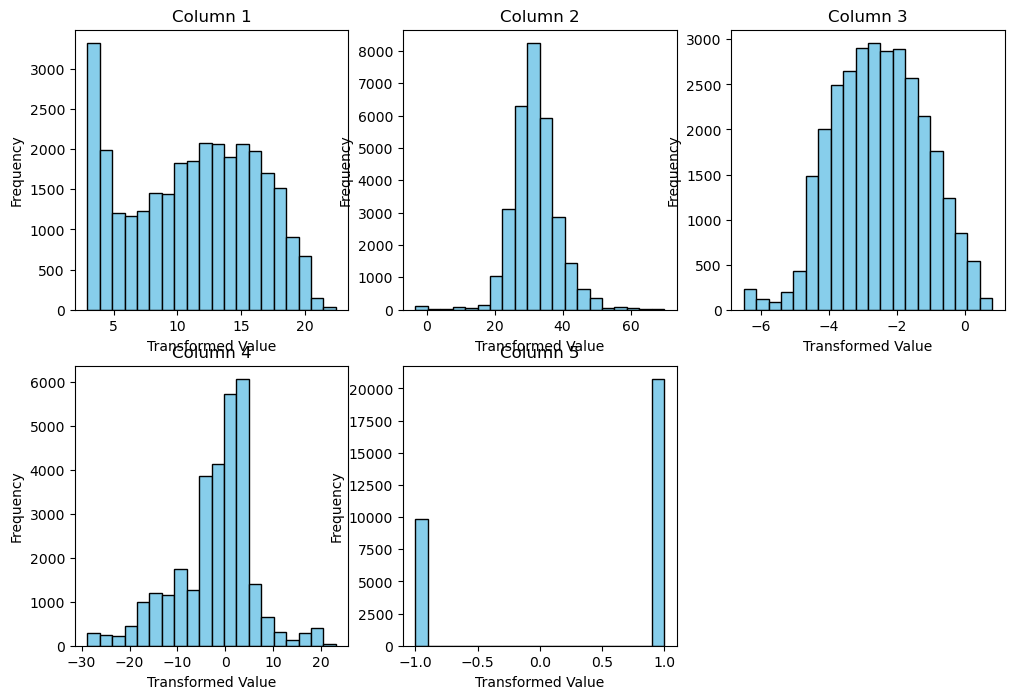

In [13]:
num_cols = transformed_train_X.shape[1]
fig, axs = plt.subplots(2, num_cols-2, figsize=(12, 8))

c = 0
for i in range(2):
    for j in range(3):
        if i * 3 + j < 5:
            axs[i,j].hist(transformed_train_X[:, c], bins=20, color='skyblue', edgecolor='black')
            axs[i,j].set_title(f'Column {c+1}')
            axs[i,j].set_xlabel('Transformed Value')
            axs[i,j].set_ylabel('Frequency')
            c = c + 1
# Remove the last subplot
fig.delaxes(axs[1, 2])

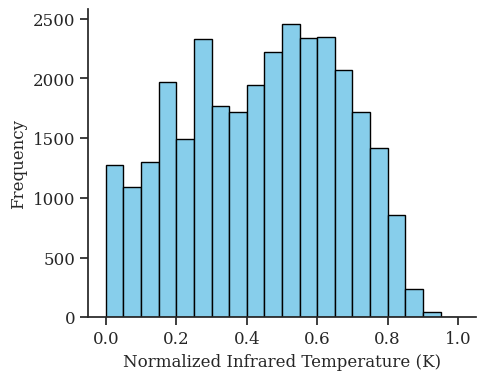

In [207]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

#axs.hist(train_Y, bins=20, color='skyblue', edgecolor='black')
#axs.hist(transformed_train_Y, bins=20, color='skyblue', edgecolor='black')
axs.hist(normalized_Y_train, bins=20, color='skyblue', edgecolor='black')
#axs.set_title('Transformed Train Label')
axs.set_xlabel('Normalized Infrared Temperature (K)')
axs.set_ylabel('Frequency')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.savefig('Original_data.png', dpi = 300, bbox_inches='tight')
#plt.savefig('transformed_data.png', dpi = 300, bbox_inches='tight')
plt.savefig('normalized_data.png', dpi = 300, bbox_inches='tight')

In [15]:
# Apply Min-Max scaling to transform the data to the range [-1, 1]
scaler_train_X = MinMaxScaler(feature_range=(0, 1))
scaler_train_Y = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform both training and testing data
normalized_X_train = scaler_train_X.fit_transform(transformed_train_X)
normalized_Y_train = scaler_train_Y.fit_transform(transformed_train_Y)

Text(0, 0.5, 'Frequency')

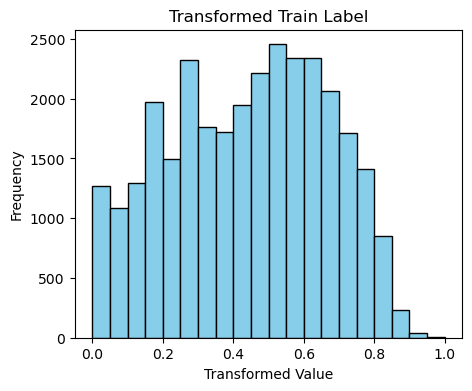

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.hist(normalized_Y_train, bins=20, color='skyblue', edgecolor='black')
axs.set_title('Transformed Train Label')
axs.set_xlabel('Transformed Value')
axs.set_ylabel('Frequency')

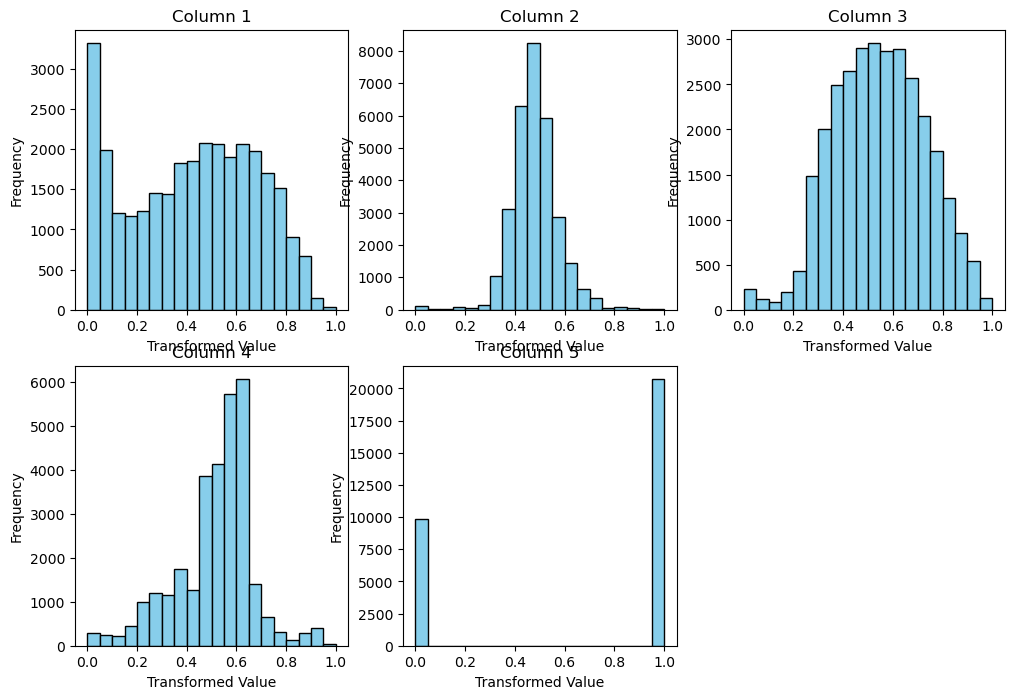

In [21]:
num_cols = normalized_X_train.shape[1]
fig, axs = plt.subplots(2, num_cols-2, figsize=(12, 8))

c = 0
for i in range(2):
    for j in range(3):
        if i * 3 + j < 5:
            axs[i,j].hist(normalized_X_train[:, c], bins=20, color='skyblue', edgecolor='black')
            axs[i,j].set_title(f'Column {c+1}')
            axs[i,j].set_xlabel('Transformed Value')
            axs[i,j].set_ylabel('Frequency')
            c = c + 1
# Remove the last subplot
fig.delaxes(axs[1, 2])

In [220]:
# TRAIN MY NEURAL NETWORK

import keras.backend as K
from keras.layers import Dense, Dropout


# Define custom loss function for RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Define custom Huber loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = K.abs(error) < delta
    squared_loss = 0.5 * K.square(error)
    linear_loss = delta * (K.abs(error) - 0.5 * delta)
    return K.mean(K.switch(is_small_error, squared_loss, linear_loss))
    
#np.random.seed(123)
keras.utils.set_random_seed(85) # BEST FOR NOW
model = keras.Sequential()
model.add(keras.Input(shape=(5,), name="input_layer")) # 2 input variables

model.add(keras.layers.Dense(units=42, activation=keras.activations.relu)) # 8 neurons
model.add(keras.layers.Dense(units=62, activation=keras.activations.relu)) # 8 neurons
model.add(keras.layers.Dense(units=54, activation=keras.activations.relu)) # 8 neurons
model.add(keras.layers.Dense(units=14, activation=keras.activations.relu)) # 8 neurons
model.add(keras.layers.Dense(units=34, activation=keras.activations.relu)) # 8 neurons

model.add(keras.layers.Dense(units=1)) #1 output

In [221]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.004569579155191588),
    #optimizer=keras.optimizers.Adam(learning_rate=0.0017487297202699033),
    loss=huber_loss
    #loss='mse'
    #loss=root_mean_squared_error
)


In [222]:
history = model.fit(
    x=normalized_X_train,
    y=normalized_Y_train,
    batch_size=32,
    epochs=150,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/150
860/860 [==============================] - 2s 1ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 2/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 3/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 4/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 5/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 6/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 7/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 8/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 9/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 10/150
860/860 [==============================] - 1s 1ms/step - loss: 0.0120 - val_lo

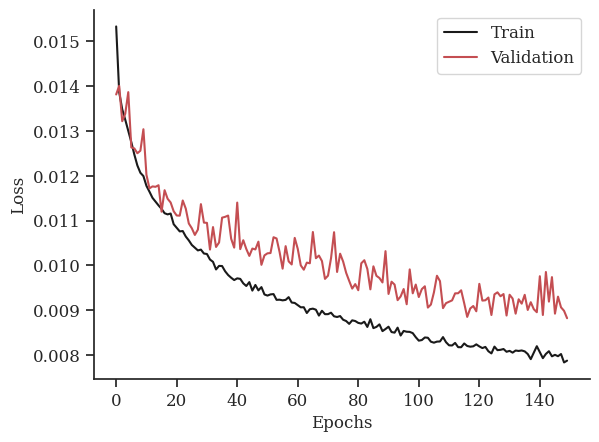

In [225]:
plt.plot(range(0,150), history.history['loss'], c='k', label = 'Train')
plt.plot(range(0,150), history.history['val_loss'], c='r', label = 'Validation')
plt.legend(fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Loss')
plt.savefig('TrainLoss.png', dpi = 250)
plt.show()

In [212]:
transformed_test_X = np.zeros(test_X.shape)*np.NaN
transformed_test_X[:,0] = boxcox(test_X[:,0], lmbda = lambda_values_train_X[0])
transformed_test_X[:,1] = boxcox(test_X[:,1], lmbda = lambda_values_train_X[1])
transformed_test_X[:,2] = boxcox(test_X[:,2], lmbda = lambda_values_train_X[2])
#transformed_test_X[:,3] = boxcox(test_X[:,3], lmbda = lambda_values_train_X[3])
transformed_test_X[:,-2] = test_X[:,-2]
transformed_test_X[:,-1] = test_X[:,-1]

transformed_test_Y = np.zeros(test_Y.shape[0])*np.NaN
transformed_test_Y = boxcox(test_Y, lmbda = lambda_values_train_Y[0])
transformed_test_Y = transformed_test_Y.reshape(-1,1)

In [213]:
# Fit the scaler on the training data and transform both training and testing data
normalized_X_test = scaler_train_X.transform(transformed_test_X)
normalized_Y_test = scaler_train_Y.transform(transformed_test_Y)

In [214]:
# to predict, use predict call
predictions = model.predict(
    x=normalized_X_test,
)

239/239 [==============================] - 0s 637us/step


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


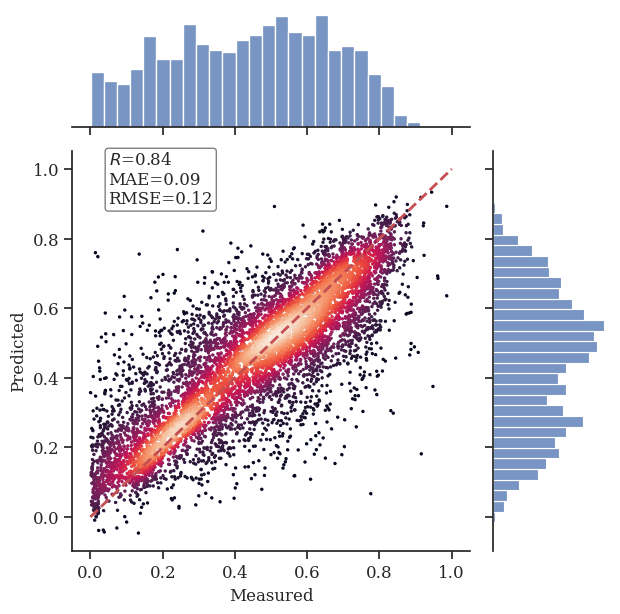

In [227]:
import sklearn
import seaborn as sns
def scatter_plot(ytrue, ypred):

    R2 = sklearn.metrics.r2_score(ytrue, ypred)
    R = np.corrcoef(normalized_Y_test.T[0], predictions.T[0])[0,1]
    MAE = sklearn.metrics.mean_absolute_error(ytrue, ypred)
    RMSE = sklearn.metrics.root_mean_squared_error(ytrue, ypred)

    xy = np.vstack([ytrue, ypred])
    z = gaussian_kde(xy)(xy)
    g = sns.jointplot(x = ytrue,
                        y = ypred,
                        height = 6,
                        ratio = 3, s = 2)

    g.ax_joint.plot([0, 1], [0, 1], '--r', linewidth=2)
    plt.scatter(ytrue, ypred, c = z, s = 2)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.grid(False)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    scores = (r'$R$={:.2f}' + '\n' + r'MAE={:.2f}' + '\n' + r'RMSE={:.2f}' ).format(
        R, MAE, RMSE)

    plt.text(0.05, 1.05, scores, bbox=dict(facecolor = 'white', edgecolor = 'gray', boxstyle = 'round, pad=0.2'),
            fontsize = 12, ha='left', va = 'top')
    plt.savefig('ValidationFig_norm.png', dpi = 300, bbox_inches='tight')
    plt.show()

scatter_plot(normalized_Y_test.T[0], predictions.T[0])

In [216]:
Y_temp = (predictions/(1 - (-0))) - (-0)
pred_original = Y_temp*(transformed_train_Y.max(axis=0) - transformed_train_Y.min(axis=0)) + transformed_train_Y.min(axis=0)

In [217]:
pred_original = inv_boxcox(pred_original, lambda_values_train_Y[0])

In [218]:
sample = pd.DataFrame(pred_original.T[0])
sample.columns = ['pred']
sample['true'] = test_Y.T
sample = sample.dropna()
sample

,pred,true
0,272.717552,264.870900
1,268.419569,268.333872
2,291.894412,294.781362
3,263.280097,253.461222
4,291.764899,292.815135
...,...,...
7636,276.558649,277.864797
7637,283.254671,280.720917
7638,283.237336,281.476166
7639,292.393254,292.494385


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


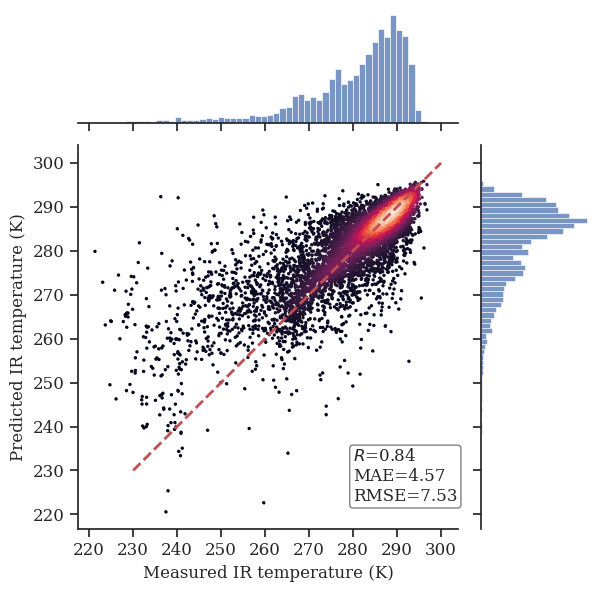

In [219]:
import sklearn
import seaborn as sns
from scipy.stats import gaussian_kde

def scatter_plot(ytrue, ypred):

    R2 = sklearn.metrics.r2_score(ytrue, ypred)
    R = np.corrcoef(normalized_Y_test.T[0], predictions.T[0])[0,1]
    MAE = sklearn.metrics.mean_absolute_error(ytrue, ypred)
    RMSE = sklearn.metrics.root_mean_squared_error(ytrue, ypred)

    g = sns.jointplot(x = ytrue,
                        y = ypred,
                        height = 6,
                        ratio = 3, s = 2)
    xy = np.vstack([ytrue, ypred])
    z = gaussian_kde(xy)(xy)

    g.ax_joint.plot([230, 300], [230, 300], '--r', linewidth=2)
    plt.scatter(ytrue, ypred, c = z, s = 2)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Measured IR temperature (K)')
    plt.ylabel('Predicted IR temperature (K)')
    plt.grid(False)

    scores = (r'$R$={:.2f}' + '\n' + r'MAE={:.2f}' + '\n' + r'RMSE={:.2f}' ).format(
        R, MAE, RMSE)

    plt.text(280, 235, scores, bbox=dict(facecolor = 'white', edgecolor = 'gray', boxstyle = 'round, pad=0.2'),
            fontsize = 12, ha='left', va = 'top')
    #plt.savefig('ValidationFig.png', dpi = 300)
    plt.show()

scatter_plot(sample['true'], sample['pred'])
#

In [147]:
from sklearn.utils import shuffle

# Define a function to calculate the performance metric on the original dataset
def original_performance_metric(model, X, y):
    y_pred = model.predict(X)
    #return huber_loss(y, y_pred, delta=1.0)
    return root_mean_squared_error(y, y_pred)
    #return sklearn.metrics.r2_score(y, y_pred)

# Define a function to calculate the performance metric after permuting each feature
def permuted_performance_metric(model, X, y, feature_index):
    X_permuted = X.copy()
    X_permuted[:, feature_index] = shuffle(X[:, feature_index])
    y_pred = model.predict(X_permuted)
    #return huber_loss(y, y_pred, delta=1.0)
    return root_mean_squared_error(y, y_pred)
    #return sklearn.metrics.r2_score(y, y_pred)

# Define a function to compute permutation feature importance
def permutation_feature_importance(model, X, y):
    baseline_score = original_performance_metric(model, X, y)
    num_features = X.shape[1]
    importance_scores = np.zeros(num_features)
    for i in range(num_features):
        permuted_score = permuted_performance_metric(model, X, y, i)
        importance_scores[i] = baseline_score - permuted_score
    return importance_scores

In [148]:
importance_scores = permutation_feature_importance(model, normalized_X_test, normalized_Y_test)

239/239 [==============================] - 0s 619us/step


([<matplotlib.axis.XTick at 0x7fc625c3bbb0>,
 [Text(0, 0, 'CAPE'),
  Text(1, 0, 'CPC'),
  Text(2, 0, 'lwp'),
  Text(3, 0, 'Coupling_Flag'),
  Text(4, 0, '500.0')])

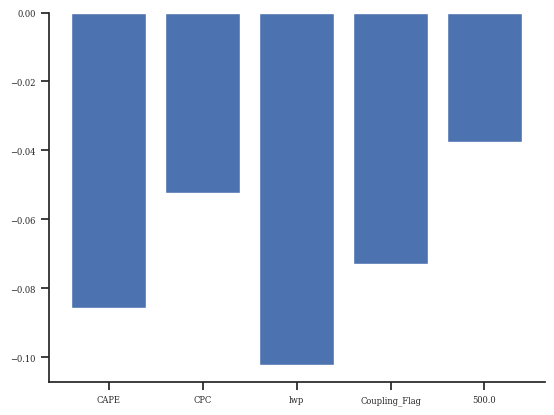

In [149]:
plt.bar(range(5),importance_scores)
plt.xticks(range(5), ['CAPE','CPC','lwp','Coupling_Flag','500.0'])

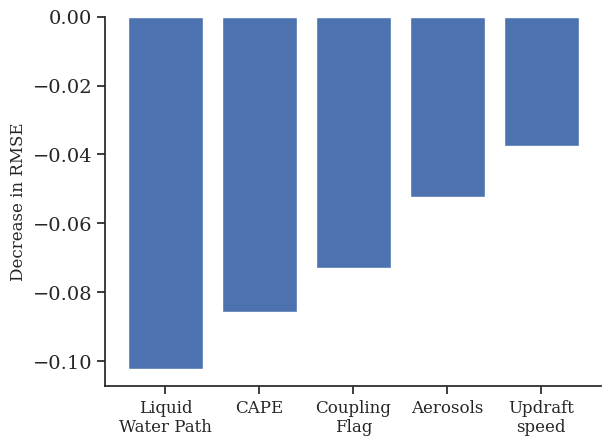

In [229]:
plt.bar(range(5),sorted(importance_scores))
plt.yticks(fontsize = 14)
plt.ylabel('Decrease in RMSE')
plt.xticks(range(5), ['Liquid\nWater Path','CAPE','Coupling\nFlag','Aerosols','Updraft\nspeed'], fontsize = 12)
plt.savefig('Featureimportance.png', dpi = 300, bbox_inches='tight')

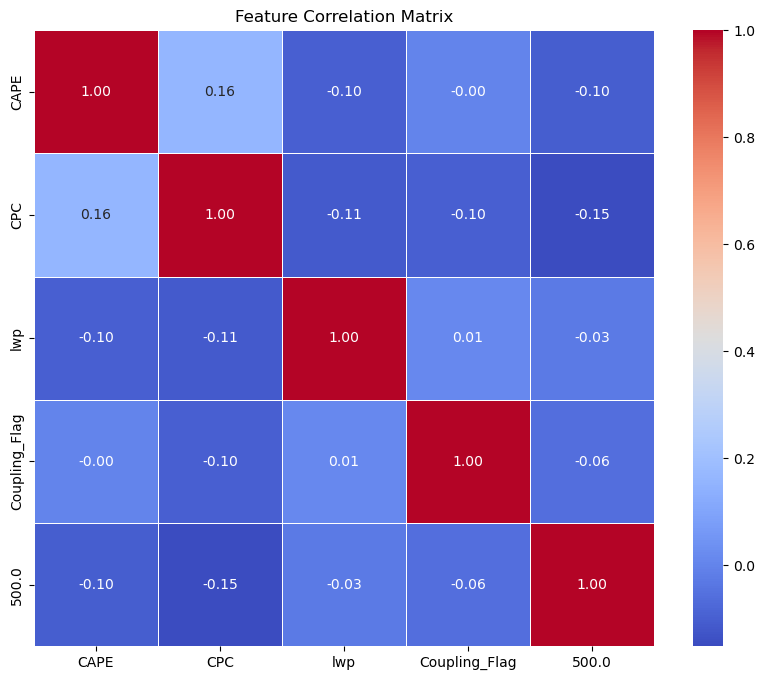

In [64]:
# Assuming 'X' is your feature matrix
# Create a DataFrame from your features
df = pd.DataFrame(normalized_X_train, columns=['CAPE','CPC','lwp','Coupling_Flag','500.0'])

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()